In [1]:
import os
import ase
from ase import io
from ase.visualize import view
from ase import gui 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
systems=io.read('system.dump', format='lammps-dump-text')

In [4]:
view(systems, viewer='x3d')

In [5]:
!cat settings.mod

# set boundary in main script because ffield is periodic
units 	real

atom_style 	full	
pair_style 	lj/cut/coul/long 16
bond_style 	harmonic
angle_style 	harmonic
kspace_style 	pppm/electrode 1e-7
# kspace_modify in main script because ffield is periodic

read_data 	"data.graph-il"

# replicate 4 4 1 # test different sys sizes

variable 	zpos atom "z > 0"
group 		zpos variable zpos
group 		ele type 5
group 		top intersect ele zpos
group 		bot subtract ele top
group       cation type 4
group       anion type 1

compute        den1 cation chunk/atom bin/1d z center 0.5  units box
fix            chunk1 cation ave/chunk 10 1 100 den1 density/number ave running file cat_density.txt overwrite
compute        den2 anion chunk/atom bin/1d z center 0.5 units box
fix            chunk2 anion ave/chunk 10 1 100 den2 density/number ave running file an_density.txt overwrite

dump            1 all custom 100 system.dump id type q xs ys zs ix iy iz
dump            2 top custom 5000 anode.dump id type q

In [6]:
!more in.conp

# electrodes with constant potential for graphene-ionic liquid supercapacitor

boundary 		p p f        	# slab calculation
include 		settings.mod 	# styles, groups, computes and fixes
kspace_modify 		slab 3.0     	# amat twostep

fix 			conp bot electrode/conp -3.0 1.979 couple top 3.0 symm o
n 	#fix for the cpm calculation 

thermo 			50
thermo_style 		custom step temp c_ctemp epair etotal c_qbot c_qtop	
	# on screen outputs
run 			5000


In [7]:
!head -50 data.graph-il

LAMMPS data file. CGCMM style. atom_style full generated by VMD/TopoTools v1.7 on Tue Oct 26 13:05:08 AEST 2021
 
 3776 atoms
 640 bonds
 320 angles
 6 atom types
 2 bond types
 1 angle types
 
0 32.2 xlo xhi
0 34.4 ylo yhi
-68 68 zlo zhi

 Masses

 1 67.070000 # Roy-Maroncelli BMI1
 2 15.040000 # Roy-Maroncelli BMI2
 3 57.119999 # Roy-Maroncelli BMI3
 4 144.960007 # Roy-Maroncelli PF64
 5 12.001000 # carbon 5
 6 12.001000 # carbon 5

Pair Coeffs # lj/cut/coul/long

1 0.61185 4.38
2 0.08604 3.41
3 0.43738 5.04
4 1.12572 5.06
5 0.05497 3.37
6 0.05497 3.37

Bond Coeffs # harmonic

1 200 2.7076
2 200 3.8213

Angle Coeffs # harmonic

1 200 116.035

 Atoms # full

1 1 1 0.437400 8.377842 31.090574 -9.637913 # 1 
2 1 2 0.157800 10.887448 30.521875 -10.101788 # 2 
3 1 3 0.184800 7.272466 32.073307 -6.141911 # 3 
4 2 4 -0.780000 11.760302 6.359865 -37.432594 # 4 
5 3 1 0.437400 3.942210 0.867467 -45.959846 # 1 
6 3 2 0.157800 6.352199 0.209895 -46.791821 # 2 
7 3 3 0.184800 2.954508 -0.392299 

In [8]:
!/ocean/projects/che240027p/shared/software/Team_BSU/lammps-CPM/src/lmp_serial -i in.conp

LAMMPS (2 Aug 2023 - Update 2)
Reading data file ...
  orthogonal box = (0 0 -68) to (32.2 34.4 68)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  3776 atoms
  scanning bonds ...
  2 = max bonds/atom
  scanning angles ...
  1 = max angles/atom
  reading bonds ...
  640 bonds
  reading angles ...
  320 angles
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0       
  special bond factors coul:  0        0        0       
     2 = max # of 1-2 neighbors
     1 = max # of 1-3 neighbors
     1 = max # of 1-4 neighbors
     2 = max # of special neighbors
  special bonds CPU = 0.002 seconds
  read_data CPU = 0.056 seconds
1891 atoms in group zpos
832 atoms in group ele
416 atoms in group top
416 atoms in group bot
320 atoms in group cation
320 atoms in group anion
960 atoms in group bmi
1280 atoms in group electrolyte
Finding SHAKE clusters ...
       0 = # of size 2 clusters
       0 = # of size 3 clusters
       0 = # of size 4 clusters
     320 = 

In [9]:
df = pd.read_csv('elec_char.txt', sep=' ')

<AxesSubplot:xlabel='time'>

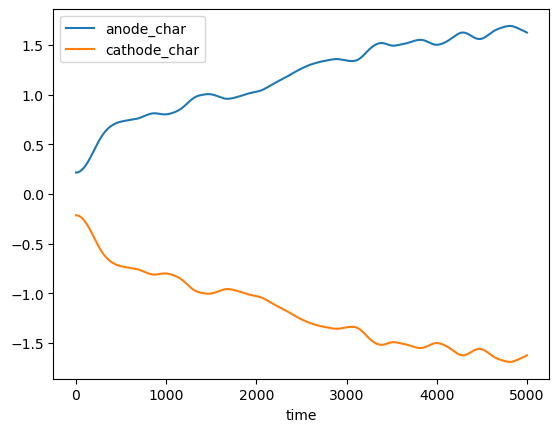

In [10]:
df.plot(x='time', y=(['anode_char','cathode_char']))

In [11]:
df1 = pd.read_csv('cat_density.txt',header = None, sep=' ', skiprows=4, names=['distance / A', 'cation density', 'density' ])
df2 = pd.read_csv('an_density.txt',header = None, sep=' ', skiprows=4, names=['distance / A', 'anion density', 'density' ])

<AxesSubplot:xlabel='distance / A'>

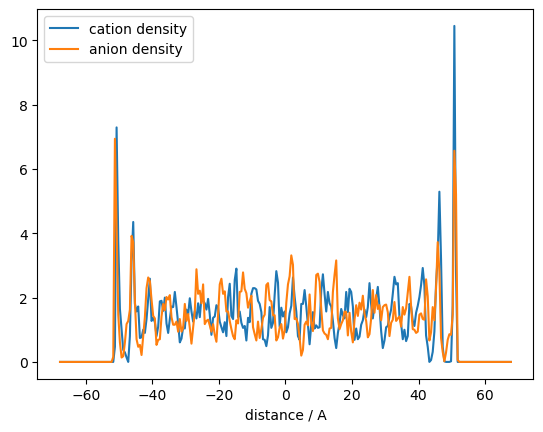

In [12]:
df1.insert(0, 'anion density',df2['anion density'])
df1.plot(x='distance / A', y=(['cation density', 'anion density']))

In [13]:
cathode_dump=io.read('cathode.dump', format='lammps-dump-text')
anode_dump=io.read('anode.dump', format ='lammps-dump-text')
cathode_charge= cathode_dump.get_initial_charges()
anode_charge=anode_dump.get_initial_charges()
c_per_atom_charge=pd.DataFrame(cathode_charge, columns=['cathode'])
a_per_atom_charge=pd.DataFrame(anode_charge, columns=['anode'])
a_per_atom_charge.insert(0, 'cathode',c_per_atom_charge['cathode'])

<AxesSubplot:>

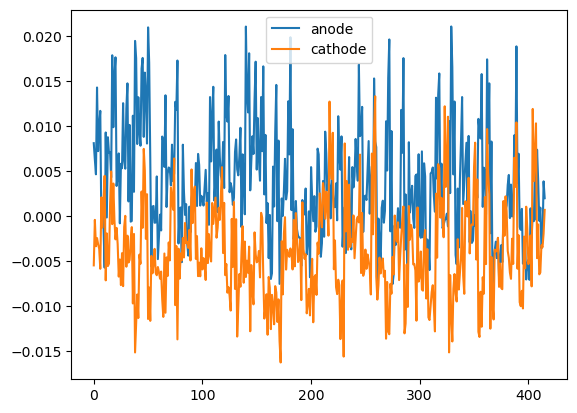

In [14]:
a_per_atom_charge.plot(y=(['anode','cathode']))